In [1]:
%run 'Lib.ipynb'

In [2]:
%mkdir 'out/3b'

mkdir: cannot create directory ‘out/3b’: File exists


In [3]:
from collections import defaultdict
import pickle

In [4]:
from PIL import Image

In [5]:
import keras.backend as K
from keras.datasets import mnist
from keras.layers import *
from keras.layers.convolutional import *
from keras.layers.noise import GaussianNoise
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import *
from keras.backend.common import _EPSILON
from keras.utils.generic_utils import Progbar

Using TensorFlow backend.


In [6]:
Z_SIZE = 100

# batch and latent size taken from the paper
EPOCHS = 50
BATCH_SIZE = 100

# Adam parameters suggested in https://arxiv.org/abs/1511.06434
ADAM_LR = 0.0002
ADAM_BETA_1 = 0.5

In [7]:
np.random.seed(777)

In [8]:
K.set_image_dim_ordering('tf')

In [9]:
# ???
def modified_binary_crossentropy(y_true, y_pred):
#     output = K.clip(output, _EPSILON, 1.0 - _EPSILON)
#     return -(target * output + (1.0 - target) * (1.0 - output))
    return K.mean(y_true * y_pred)

In [10]:
def create_D():
    input_image = Input(shape=(28, 28, 1), name='input_image')

    x = Conv2D(32, (3, 3), padding='same', name='conv_1')(input_image)
    x = LeakyReLU()(x)
    x = MaxPool2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(64, (3, 3), padding='same', name='conv_2')(x)
    x = MaxPool2D(pool_size=1)(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    x = Conv2D(128, (3, 3), padding='same', name='conv_3')(x)
    x = MaxPool2D(pool_size=2)(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    x = Conv2D(256, (3, 3), padding='same', name='coonv_4')(x)
    x = MaxPool2D(pool_size=1)(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    features = Flatten()(x)

    output_is_fake = Dense(
        1, activation='linear', name='output_is_fake')(features)
    output_class = Dense(
        10, activation='softmax', name='output_class')(features)

    return Model(inputs=[input_image], outputs=[output_is_fake, output_class], name='D')

In [11]:
def create_G(Z_SIZE=Z_SIZE):
    DICT_LEN = 10
    EMBEDDING_LEN = Z_SIZE

    # class#
    input_class = Input(shape=(1, ), dtype='int32', name='input_class')
    # encode class# to the same size as Z to use hadamard multiplication later on
    e = Embedding(
        DICT_LEN, EMBEDDING_LEN,
        embeddings_initializer='glorot_uniform')(input_class)
    embedded_class = Flatten(name='embedded_class')(e)

    # latent var
    input_z = Input(shape=(Z_SIZE, ), name='input_z')

    # hadamard product
    h = multiply([input_z, embedded_class], name='h')

    # cnn part
    x = Dense(1024)(h)
    x = LeakyReLU()(x)

    x = Dense(128 * 7 * 7)(x)
    x = LeakyReLU()(x)
    x = Reshape((7, 7, 128))(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(256, (5, 5), padding='same')(x)
    x = LeakyReLU()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, (5, 5), padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2D(1, (2, 2), padding='same', activation='tanh', name='output_generated_image')(x)

    return Model(inputs=[input_z, input_class], outputs=x, name='G')

In [12]:
D = create_D()

D.compile(
    optimizer=SGD(clipvalue=0.01),
    loss=[modified_binary_crossentropy, 'sparse_categorical_crossentropy'])

In [13]:
G = create_G()

G.compile(
    optimizer=Adam(lr=ADAM_LR, beta_1=ADAM_BETA_1), loss='binary_crossentropy')

In [14]:
input_z = Input(shape=(Z_SIZE, ), name='input_z_')
input_class = Input(shape=(1, ),name='input_class_', dtype='int32')

In [15]:
# create combined D(G) model
# D.trainable = False
output_is_fake, output_class = D(G(inputs=[input_z, input_class]))
combined = Model(inputs=[input_z, input_class], outputs=[output_is_fake, output_class])
combined.get_layer('D').trainable = False # freeze D in generator training faze

combined.compile(
    optimizer='RMSprop',
    loss=[modified_binary_crossentropy, 'sparse_categorical_crossentropy']
)

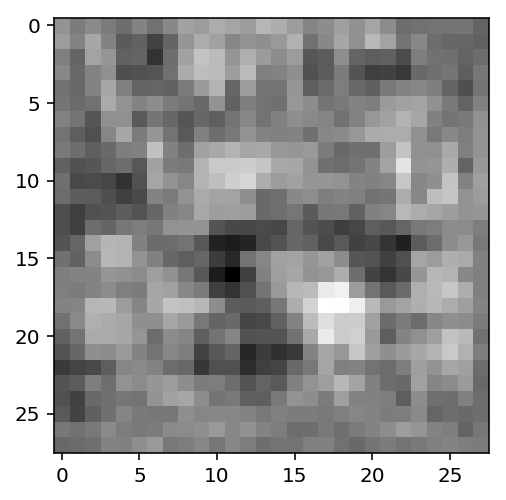

In [16]:
# try generating image

z = np.random.randn(100).reshape(1, 100)
img = G.predict([z, np.array([8])])
plt.imshow(img.reshape((28, 28)), cmap=plt.cm.gray)

In [17]:
# get our mnist data, and force it to be of shape (..., 28, 28, 1) with
# range [-1., 1.]
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)

X_test = (X_test.astype(np.float32) - 127.5) / 127.5
X_test = np.expand_dims(X_test, axis=3)

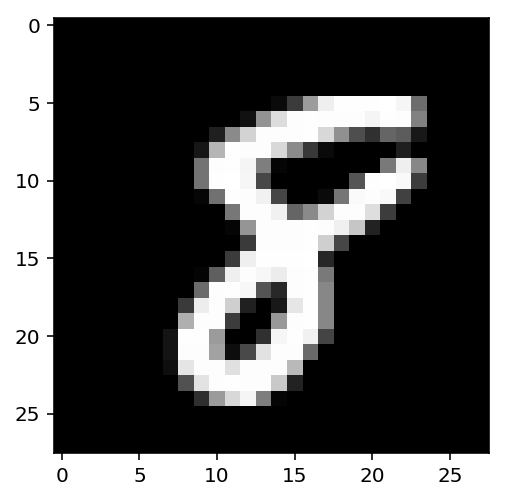

In [18]:
plt.imshow(X_train[777].reshape((28, 28)), cmap=plt.cm.gray)

In [19]:
train_num_samples, test_num_samples = X_train.shape[0], X_test.shape[0]

In [20]:
train_history = defaultdict(list)
test_history = defaultdict(list)

In [30]:
def save_generated_samples(epoch, G):

    # new batch of z's
    zz = np.random.normal(0., 1., (100, Z_SIZE))

    # new batch of classes [0..9]
    generated_classes = np.array(list(range(0, 10)) * 10, dtype=np.int32)

    generated_images = G.predict([zz, generated_classes.reshape(-1, 1)])

    rr = []
    for c in range(10):
        rr.append(
            np.concatenate(generated_images[c * 10:(1 + c) * 10]).reshape(
                280, 28))
    img = np.hstack(rr)

    plt.imsave('out/3b/generated-e%d.png' % epoch, img, cmap=plt.cm.gray)

In [ ]:
for epoch in range(EPOCHS):

    print('\nEpoch {} / {}'.format(epoch + 1, EPOCHS))

    batches_num = int(train_num_samples / BATCH_SIZE)
    progress_bar = Progbar(target=batches_num)

    epoch_combined_losses = []
    epoch_D_losses = []

    for batch_i in range(batches_num):

        if len(epoch_D_losses) + len(epoch_combined_losses) > 1:
            progress_bar.update(
                batch_i,
                values=[
                        ('D_loss', np.mean(np.array(epoch_D_losses), axis=0)[0]),
                        ('D(G)_loss', np.mean(np.array(epoch_combined_losses),axis=0)[0])
                ]
            )
        else:
            progress_bar.update(batch_i)
            
        # 1: train D on real+generated images
            
        # create batches of images and labels
        real_images = X_train[batch_i * BATCH_SIZE:(batch_i + 1) * BATCH_SIZE]
        real_images_classes = y_train[batch_i * BATCH_SIZE:(batch_i + 1) * BATCH_SIZE]
        
        # new batch of z's
        zz = np.random.normal(0., 1., (BATCH_SIZE, Z_SIZE))
        
        # new batch of classes [0..9]
        generated_classes = np.random.randint(0, 10, BATCH_SIZE)
        
        generated_images = G.predict([zz, generated_classes.reshape(-1, 1)])
        
        X = np.concatenate((real_images, generated_images))
        y_is_fake = np.array([-1] * BATCH_SIZE + [1] * BATCH_SIZE) # [is_fake=-1xBATCH_SIZE, 1xBATCH_SIZE]
        y_classes = np.concatenate((real_images_classes, generated_classes))
        
        # train 
        D_losses = D.train_on_batch(X, [y_is_fake, y_classes])
        epoch_D_losses.append(D_losses)
        
        
        # 2: train D(G) (only G is trainable)
        
        # 2x so G is trained for the same number of images
        # as D above (which is trained on real+generated)
        zz = np.random.normal(0., 1., (2 * BATCH_SIZE, Z_SIZE)) 
        generated_classes = np.random.randint(0, 10, 2 * BATCH_SIZE)

        y_is_fake = -np.ones(2 * BATCH_SIZE) # all not-fake

        combined_losses = combined.train_on_batch(
            [zz, generated_classes.reshape((-1, 1))],
            [y_is_fake, generated_classes])
        
        epoch_combined_losses.append(combined_losses)
        
    print('\nD:', D.metrics_names)
    print(np.mean(np.array(epoch_D_losses), axis=0).tolist())
    
    print('D(G):', combined.metrics_names)
    print(np.mean(np.array(epoch_combined_losses), axis=0).tolist())
    
    save_generated_samples(epoch, G)


Epoch 1 / 50
599/600 [============================>.] - ETA: 0s - D_loss: 2.0345 - D(G)_loss: 2.1246
D: ['loss', 'output_is_fake_loss', 'output_class_loss']
[1.4295319318771362, 0.007126178592443466, 1.4224066734313965]
D(G): ['loss', 'D_loss', 'D_loss']
[1.1916042566299438, -0.14951910078525543, 1.341122031211853]

Epoch 2 / 50
599/600 [============================>.] - ETA: 0s - D_loss: 0.3197 - D(G)_loss: -0.9730
D: ['loss', 'output_is_fake_loss', 'output_class_loss']
[0.2895541489124298, 0.02179291844367981, 0.26776131987571716]
D(G): ['loss', 'D_loss', 'D_loss']
[-0.9964799880981445, -1.0358372926712036, 0.03935704007744789]

Epoch 3 / 50
599/600 [============================>.] - ETA: 0s - D_loss: 0.2420 - D(G)_loss: -1.1303
D: ['loss', 'output_is_fake_loss', 'output_class_loss']
[0.2277207374572754, 0.02510138787329197, 0.20261940360069275]
D(G): ['loss', 'D_loss', 'D_loss']
[-1.2031484842300415, -1.2249082326889038, 0.02175978571176529]

Epoch 4 / 50
599/600 [=================

599/600 [============================>.] - ETA: 0s - D_loss: 0.0534 - D(G)_loss: -2.9033
D: ['loss', 'output_is_fake_loss', 'output_class_loss']
[0.05069008097052574, 0.014183834195137024, 0.036506250500679016]
D(G): ['loss', 'D_loss', 'D_loss']
[-2.953293561935425, -2.960998058319092, 0.007704651448875666]

Epoch 45 / 50
599/600 [============================>.] - ETA: 0s - D_loss: 0.0485 - D(G)_loss: -2.8524
D: ['loss', 'output_is_fake_loss', 'output_class_loss']
[0.048887740820646286, 0.01393364928662777, 0.03495410457253456]
D(G): ['loss', 'D_loss', 'D_loss']
[-2.836778163909912, -2.844243049621582, 0.007463573478162289]

Epoch 46 / 50
599/600 [============================>.] - ETA: 0s - D_loss: 0.0533 - D(G)_loss: -2.8249
D: ['loss', 'output_is_fake_loss', 'output_class_loss']
[0.05112990364432335, 0.015551096759736538, 0.03557882085442543]
D(G): ['loss', 'D_loss', 'D_loss']
[-2.920527696609497, -2.9281723499298096, 0.007643483579158783]

Epoch 47 / 50
599/600 [====================

In [31]:
save_generated_samples(101, G)